<a href="https://colab.research.google.com/github/mjkimcs/portfolio/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EB%B6%84%EB%A5%98/%EC%B2%A0%ED%8C%90%EC%A0%9C%EC%A1%B0%EA%B3%B5%EC%A0%95_%ED%95%98%EC%9D%B4%ED%8D%BC%ED%8C%8C%EB%A6%AC%EB%AF%B8%ED%84%B0%ED%8A%9C%EB%8B%9D_%EC%8B%AC%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **프로젝트 목표**
1. 캐글 제조공정 데이터를 활용하여 불량의 종류 중 하나인 K_Scatch에 속하는지(1) 아닌지(0) 분류하기  

2. 7개의 분류모델을 이해하고 사용해보기
```
  - 7개의 모델 : LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, Support Vector Machine, MLPClassifier, XGBClassifier, LGBMClassifier 
```
3. 각 모델의 주요 하이퍼파리미터 튜닝 공부하기


## **프로젝트 결과**
1. 7개의 분류모델 중 Random Forest, ANN, XGBoost, lightGBM이 Accuracy 0.985로 제일 높은 성능을 보였음
2. 인공신경망 모델인 MLPClassifier에서 히든레이어의 수 2개 이상보다 1개일 때의 정확도가 약0.0014 높았음
3. 그리드서치를 사용하여 최적 하이퍼파라미터를 찾는 데 노력하였고, 7개 모델 모두 0.9 이상의 Accuracy를 얻음


## 데이터셋 구성
- size : 총 1941개의 row와 34개의 column
- feature : 철판의 두께, 타입, 길이 등 총 27개
- 데이터출처:   
https://www.kaggle.com/mahsateimourikia/faults-nna  
http://archive.ics.uci.edu/ml/datasets/steel+plates+faults



## 데이터 불러오기

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

path = "/content/drive/MyDrive/P3C1"
file_list = os.listdir(path)
print ("file_list: {}".format(file_list))

file_list: ['Faults27x7_var', 'Faults.NNA', '__pycache__', 'testing.py']


In [ ]:
os.chdir('/content/drive/MyDrive/P3C1/')

In [ ]:
import pandas as pd 
import numpy as np

In [ ]:
# TSV(콤마 대신 Tab으로 컬럼을 분리하는 파일포맷) 파일이므로 delimiter='\t' 옵션 지정
# 컬럼명이 없는 파일이므로 header=None 옵션 지정

df = pd.read_csv('Faults.NNA',  delimiter='\t', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


In [ ]:
# 컬럼정보 불러오기

columns_name=pd.read_csv('Faults27x7_var',  delimiter=' ', header=None)
columns_name

,0
0,X_Minimum
1,X_Maximum
2,Y_Minimum
3,Y_Maximum
4,Pixels_Areas
5,X_Perimeter
6,Y_Perimeter
7,Sum_of_Luminosity
8,Minimum_of_Luminosity
9,Maximum_of_Luminosity


In [ ]:
# 컬럼정보 매칭

df.columns = columns_name[0]
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


In [ ]:
df.shape

(1941, 34)

In [ ]:
# CPU 개수 확인

n_cpu = os.cpu_count()
print("The number of cpus: ", n_cpu)
n_thread = n_cpu * 2
print("Expected number of threads:", n_thread)

The number of cpus:  2
Expected number of threads: 4


## 탐색적 데이터 분석(EDA) 및 데이터 전처리

### 종속변수 범주화

In [ ]:
conditions=[
            df['Pastry'],
            df['Z_Scratch'],
            df['K_Scatch'],
            df['Stains'],
            df['Dirtiness'],
            df['Bumps'],
            df['Other_Faults'] 
]
conditions = list(map(lambda i: i.astype(bool), conditions))

In [ ]:
print(type(conditions))
print(type(conditions[0]))
print(len(conditions))
print(len(conditions[0]))

<class 'list'>
<class 'pandas.core.series.Series'>
7
1941


In [ ]:
# select 함수는 list 각 원소별로 TRUE인 것들의 값을 지정

cat = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
df['class'] = np.select(conditions, cat)
df.sample(5)

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,class
483,39,192,1831860,1832017,11809,621,400,1367596,36,141,1400,0,1,40,0.0557,0.5084,0.9745,0.1093,0.2464,0.3925,1.0,4.0722,2.1847,2.1959,0.0255,-0.0952,1.0000,0,0,1,0,0,0,0,K_Scatch
978,828,837,2451285,2451296,67,13,11,8107,112,134,1350,0,1,40,0.7600,0.3232,0.8182,0.0067,0.6923,1.0000,1.0,1.8261,0.9542,1.0414,0.1818,-0.0547,0.2051,0,0,0,0,0,1,0,Bumps
566,41,190,462709,462786,6232,250,130,648220,48,133,1356,0,1,40,0.0605,0.4568,0.5168,0.1099,0.5960,0.5923,0.0,3.7946,2.1732,1.8865,-0.4832,-0.1874,1.0000,0,0,1,0,0,0,0,K_Scatch
340,1211,1229,840091,840385,1733,206,294,185716,93,133,1362,0,1,175,0.1953,0.6725,0.0612,0.0132,0.0874,1.0000,1.0,3.2388,1.2553,2.4683,0.9388,-0.1628,1.0000,0,1,0,0,0,0,0,Z_Scratch
60,707,714,807870,807880,53,10,10,5039,81,111,1360,1,0,100,0.9500,0.2429,0.7000,0.0052,0.7000,1.0000,1.0,1.7243,0.8451,1.0000,0.3000,-0.2572,0.1753,1,0,0,0,0,0,0,Pastry


In [ ]:
df['class'].value_counts()

Other_Faults    673
Bumps           402
K_Scatch        391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
Name: class, dtype: int64

### 결측치 확인하기

In [ ]:
df.isna().sum()

0
X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
class                    0
dtype: int64

### 변수간의 상관관계 파악 1. 산점도

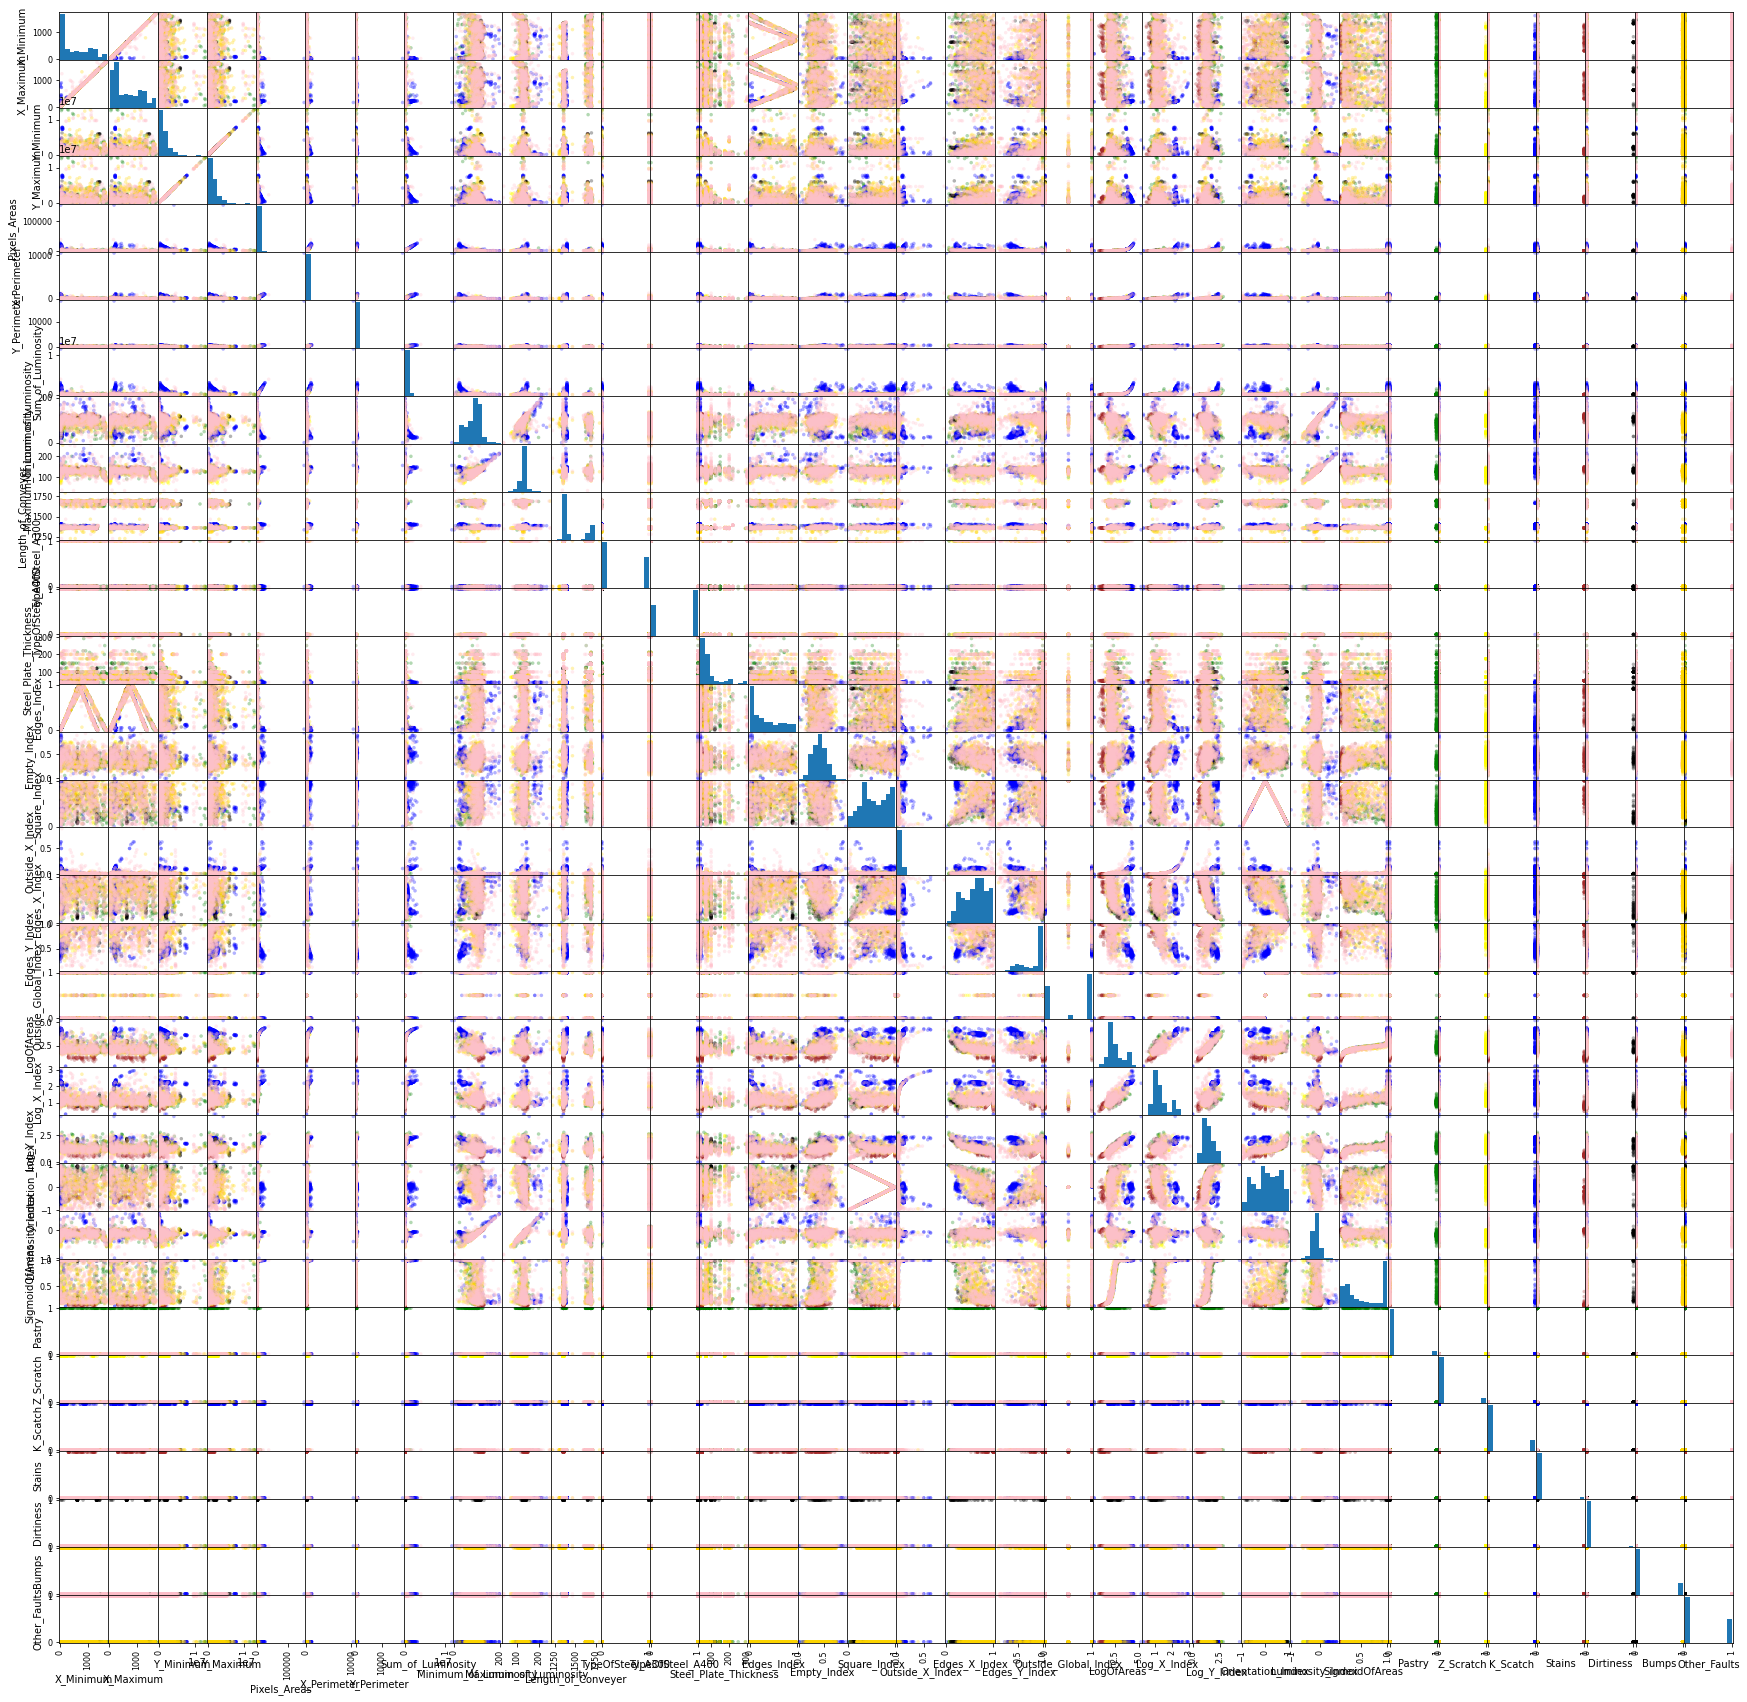

In [ ]:
import matplotlib.pyplot as plt

color_code = {'Pastry':'Green', 'Z_Scratch':'Yellow', 'K_Scatch':'Blue', 'Stains':'Brown', 'Dirtiness':'Black', 'Bumps':'Gold', 'Other_Faults':'Pink'}
color_list = [color_code.get(i) for i in df.loc[ :, 'class']] 

pd.plotting.scatter_matrix(df.loc[ :, df.columns != 'class'], c = color_list, figsize = [30,30], alpha = 0.3, s = 50, diagonal = 'hist');

### 변수간의 상관관계 파악 2. heatmap

In [ ]:
df.columns

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults', 'class'],
      dtype='object', name=0)

In [ ]:
df_cor = df[['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas']]

In [ ]:
corr = df_cor.corr()
corr

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,,,,,,,,,,,,,,,,,,,,,,,,,,,
X_Minimum,1.000000,0.988314,0.041821,0.041807,-0.307322,-0.258937,-0.118757,-0.339045,0.237637,-0.075554,0.316662,0.144319,-0.144319,0.136625,0.278075,-0.198461,0.063658,-0.361160,0.154778,0.367907,0.147282,-0.428553,-0.437944,-0.326851,0.178585,-0.031578,-0.355251
X_Maximum,0.988314,1.000000,0.052147,0.052135,-0.225399,-0.186326,-0.090138,-0.247052,0.168649,-0.062392,0.299390,0.112009,-0.112009,0.106119,0.242846,-0.152680,0.048575,-0.214930,0.149259,0.271915,0.099253,-0.332169,-0.324012,-0.265990,0.115019,-0.038996,-0.286736
Y_Minimum,0.041821,0.052147,1.000000,1.000000,0.017670,0.023843,0.024150,0.007362,-0.065703,-0.067785,-0.049211,0.075164,-0.075164,-0.207640,0.021314,-0.043117,-0.006135,0.054165,0.066085,-0.036543,-0.062911,0.044952,0.070406,-0.008442,-0.086497,-0.090654,0.025257
Y_Maximum,0.041807,0.052135,1.000000,1.000000,0.017840,0.024038,0.024380,0.007499,-0.065733,-0.067776,-0.049219,0.075151,-0.075151,-0.207644,0.021300,-0.043085,-0.006152,0.054185,0.066051,-0.036549,-0.062901,0.044994,0.070432,-0.008382,-0.086480,-0.090666,0.025284
Pixels_Areas,-0.307322,-0.225399,0.017670,0.017840,1.000000,0.966644,0.827199,0.978952,-0.497204,0.110063,-0.155853,-0.235591,0.235591,-0.183735,-0.275289,0.272808,0.017865,0.588606,-0.294673,-0.463571,-0.109655,0.650234,0.603072,0.578342,-0.137604,-0.043449,0.422947
X_Perimeter,-0.258937,-0.186326,0.023843,0.024038,0.966644,1.000000,0.912436,0.912956,-0.400427,0.111363,-0.134240,-0.189250,0.189250,-0.147712,-0.227590,0.306348,0.004507,0.517098,-0.293039,-0.412100,-0.079106,0.563036,0.524716,0.523472,-0.101731,-0.032617,0.380605
Y_Perimeter,-0.118757,-0.090138,0.024150,0.024380,0.827199,0.912436,1.000000,0.704876,-0.213758,0.061809,-0.063825,-0.095154,0.095154,-0.058889,-0.111240,0.188825,-0.047511,0.209160,-0.195162,-0.136723,0.013438,0.294040,0.228485,0.344378,0.031381,-0.047778,0.191772
Sum_of_Luminosity,-0.339045,-0.247052,0.007362,0.007499,0.978952,0.912956,0.704876,1.000000,-0.540566,0.136515,-0.169331,-0.263632,0.263632,-0.204812,-0.301452,0.293691,0.049607,0.658339,-0.327728,-0.529745,-0.121090,0.712128,0.667736,0.618795,-0.158483,-0.014067,0.464248
Minimum_of_Luminosity,0.237637,0.168649,-0.065703,-0.065733,-0.497204,-0.400427,-0.213758,-0.540566,1.000000,0.429605,-0.023579,0.042048,-0.042048,0.103393,0.358915,-0.044111,0.066748,-0.487574,0.252256,0.316610,0.035462,-0.678762,-0.567655,-0.588208,0.057123,0.669534,-0.514797


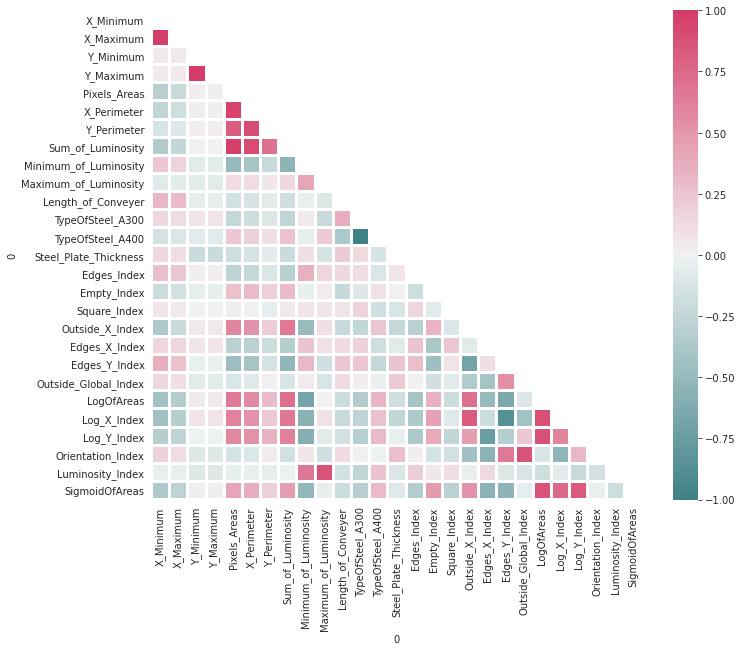

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(200, 1, as_cmap=True)

plt.figure(figsize=(11,9))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, linewidths=2)

### 범주형 변수의 분포 시각화

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


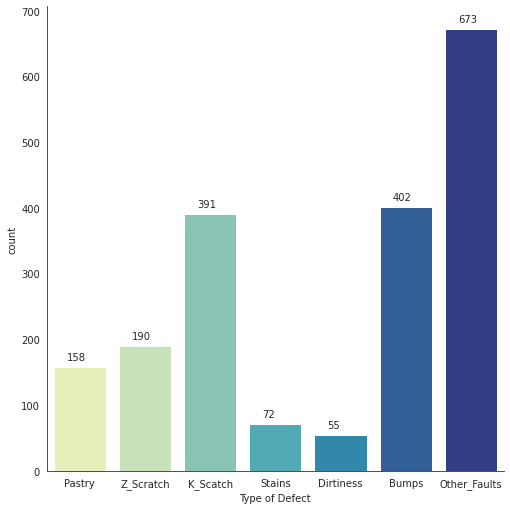

In [ ]:
import seaborn as sns

sns.set_style("white"); # darkgrid
g = sns.factorplot(x='class', data=df, kind='count', palette='YlGnBu', size=7);
g.ax.xaxis.set_label_text("Type of Defect");

# Barplot의 bar 상단에 값을 text로 달아주기
for i in g.ax.patches:
  g.ax.annotate( (i.get_height()) , (i.get_x()+0.2 ,i.get_height()+10) );

### train_test_split

In [ ]:
x = df[['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300',  'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas']]
y = df['K_Scatch']

In [ ]:
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100, stratify=y)

In [ ]:
# 표준화

x_train = x_train.apply(zscore)
x_test = x_test.apply(zscore)

In [ ]:
x_train.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
count,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03
mean,-4.528165e-17,-4.685542e-17,1.133114e-16,6.802977e-17,-6.999699e-17,-2.374962e-17,-3.809238e-18,1.223248e-17,2.106705e-16,-6.805839e-16,-2.054485e-16,-1.560893e-16,-2.094544e-16,-7.754393e-17,1.970789e-16,9.216389e-17,6.019669e-17,-3.776332e-16,5.214543e-16,-1.917138e-17,3.008046e-16,-4.355765e-16,1.969358e-16,-2.360655e-17,-8.240831e-17,-3.691205e-17
std,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00
min,-1.087842e+00,-1.223893e+00,-9.073677e-01,-9.073847e-01,-3.501466e-01,-3.457622e-01,-1.783632e-01,-3.922746e-01,-2.627821e+00,-4.905913e+00,-1.602006e+00,-8.112457e-01,-7.045937e-01,-1.116940e+00,-3.008160e+00,-2.077532e+00,-5.349128e-01,-2.457186e+00,-3.217249e+00,-1.195529e+00,-2.783736e+00,-2.148948e+00,-3.094959e+00,-2.144513e+00,-5.764150e+00,-1.376902e+00
25%,-9.832236e-01,-8.454353e-01,-6.623070e-01,-6.623256e-01,-3.351017e-01,-3.056494e-01,-1.530078e-01,-3.748767e-01,-6.458310e-01,-3.418391e-01,-6.895538e-01,-8.112457e-01,-7.045937e-01,-9.133484e-01,-7.214994e-01,-7.774059e-01,-4.501212e-01,-7.864613e-01,-9.134612e-01,-1.195529e+00,-7.219902e-01,-7.003725e-01,-7.130641e-01,-8.115992e-01,-4.257504e-01,-1.000250e+00
50%,-3.138608e-01,-3.364405e-01,-2.489829e-01,-2.490031e-01,-3.189559e-01,-2.717078e-01,-1.276524e-01,-3.559679e-01,1.593526e-01,-1.844572e-01,-6.477621e-01,-8.112457e-01,-1.539007e-01,-3.470671e-01,-1.520763e-02,-4.663798e-02,-3.927622e-01,1.049214e-01,5.690468e-01,8.787706e-01,-3.267364e-01,-3.354309e-01,-1.767405e-01,2.793896e-02,-1.181434e-02,-2.314848e-01
75%,9.255742e-01,9.097364e-01,2.915934e-01,2.915700e-01,-1.989173e-01,-9.197158e-02,-5.101303e-03,-2.378568e-01,6.625923e-01,4.975308e-01,1.344308e+00,1.232672e+00,2.966362e-02,8.367305e-01,6.504968e-01,9.070823e-01,-1.670669e-01,7.788133e-01,8.040000e-01,8.787706e-01,5.389607e-01,4.010839e-01,7.286090e-01,8.367349e-01,4.321267e-01,1.217036e+00
max,2.215381e+00,2.234843e+00,6.269562e+00,6.269499e+00,2.765788e+01,3.188951e+01,3.817379e+01,2.154121e+01,3.442024e+00,6.425581e+00,1.797051e+00,1.232672e+00,4.068079e+00,2.227828e+00,3.832977e+00,1.577045e+00,1.400269e+01,1.602642e+00,8.040000e-01,8.787706e-01,3.417759e+00,3.597898e+00,6.304388e+00,1.819887e+00,4.783014e+00,1.217552e+00


## Logistic Regression

- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [ ]:
lr = LogisticRegression(solver='liblinear') # penalty를 지정하지 않기 위해 liblinear 옵션 지정

### Grid Search
- Grid Search : 우리가 Search하고자 하는 것들을 Grid 형태로 구성
- C : 클수록 회귀계수들이 가질 수 있는 값의 범위제한을 많이 가함
- tol : Threshold 값이 작을수록 베타값이 아주 미세하게 변할 때 멈춤, 클수록 어느정도 수렴하면 멈춤
- cv=10 : 10등분하여 교차검증

In [ ]:
parameters = {
    'penalty':['l1','l2'],
    'C':[0.01,0.1,0.5,0.9,1,5,10],
    'tol':[1e-4,1e-2,1,1e2]
    }
GSLR = GridSearchCV(lr, parameters, cv=10, n_jobs=n_thread, scoring="accuracy")

In [ ]:
# 학습하기

GSLR.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'C': [0.01, 0.1, 0.5, 0.9, 1, 5, 10],
                         'penalty': ['l1', 'l2'],
                         'tol': [0.0001, 0.01, 1, 100.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
# 최적의 파라미터 값 및 정확도(Accuracy) 출력

print('final params', GSLR.best_params_)   
print('ACC.', GSLR.best_score_)  

final params {'C': 0.9, 'penalty': 'l1', 'tol': 0.01}
ACC. 0.9742307692307692


In [ ]:
means = GSLR.cv_results_['mean_test_score']
stds = GSLR.cv_results_['std_test_score']
params = GSLR.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%.3f (+/-%.3f) for %r"
          %(mean, std * 2, param))

0.943 (+/-0.044) for {'C': 0.01, 'penalty': 'l1', 'tol': 0.0001}
0.945 (+/-0.047) for {'C': 0.01, 'penalty': 'l1', 'tol': 0.01}
0.945 (+/-0.055) for {'C': 0.01, 'penalty': 'l1', 'tol': 1}
0.798 (+/-0.005) for {'C': 0.01, 'penalty': 'l1', 'tol': 100.0}
0.952 (+/-0.032) for {'C': 0.01, 'penalty': 'l2', 'tol': 0.0001}
0.952 (+/-0.032) for {'C': 0.01, 'penalty': 'l2', 'tol': 0.01}
0.954 (+/-0.031) for {'C': 0.01, 'penalty': 'l2', 'tol': 1}
0.798 (+/-0.005) for {'C': 0.01, 'penalty': 'l2', 'tol': 100.0}
0.966 (+/-0.021) for {'C': 0.1, 'penalty': 'l1', 'tol': 0.0001}
0.966 (+/-0.023) for {'C': 0.1, 'penalty': 'l1', 'tol': 0.01}
0.959 (+/-0.024) for {'C': 0.1, 'penalty': 'l1', 'tol': 1}
0.798 (+/-0.005) for {'C': 0.1, 'penalty': 'l1', 'tol': 100.0}
0.967 (+/-0.027) for {'C': 0.1, 'penalty': 'l2', 'tol': 0.0001}
0.967 (+/-0.027) for {'C': 0.1, 'penalty': 'l2', 'tol': 0.01}
0.961 (+/-0.027) for {'C': 0.1, 'penalty': 'l2', 'tol': 1}
0.798 (+/-0.005) for {'C': 0.1, 'penalty': 'l2', 'tol': 100.0}


### 모형 평가 : Accuracy 0.964

In [ ]:
predict = GSLR.predict(x_test)

In [ ]:
cm = confusion_matrix(y_test, predict)
print(cm)
print("\n Accuracy:", GSLR.score(x_test,y_test))

[[303   8]
 [  6  72]]

 Accuracy: 0.9640102827763496


In [ ]:
print(metrics.classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       311
           1       0.90      0.92      0.91        78

    accuracy                           0.96       389
   macro avg       0.94      0.95      0.94       389
weighted avg       0.96      0.96      0.96       389



## Decision Trees
1. 장점 : 해석력이 좋음
2. 단점 : 변동성이 심함 즉, 데이터 샘플이 조금만 달라지거나 변수 하나가 달라져도 결과차이가 있음

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier()

### Grid Search
- Prunning
  - model complexity를 낮추는 과정 : overfit 방지
  - min_samples_split, max_depth, min_samples_leaf, max_features 등을 활용

In [ ]:
parameters = {
    'criterion':['gini','entropy'],
    'min_samples_split':[1,2,3,5,10], 
    'max_depth':[None,2],
    'min_samples_leaf':[1,2,3,4,5,10],
    'max_features':[None,'sqrt','log2']
    }

In [ ]:
GSDT = GridSearchCV(dt, parameters, cv=10, n_jobs=n_thread, scoring="accuracy")
GSDT.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [ ]:
print('final params', GSDT.best_params_)
print('ACC.', GSDT.best_score_)

final params {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
ACC. 0.9780893300248138


### 모형 평가 : Accuracy 0.949

In [ ]:
predict = GSDT.predict(x_test)
cm = confusion_matrix(y_test, predict)

print(cm)
print("\n Accuracy:", round(GSDT.score(x_test,y_test), 3))
print(metrics.classification_report(y_test, predict))

[[299  12]
 [  8  70]]

 Accuracy: 0.949
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       311
           1       0.85      0.90      0.88        78

    accuracy                           0.95       389
   macro avg       0.91      0.93      0.92       389
weighted avg       0.95      0.95      0.95       389



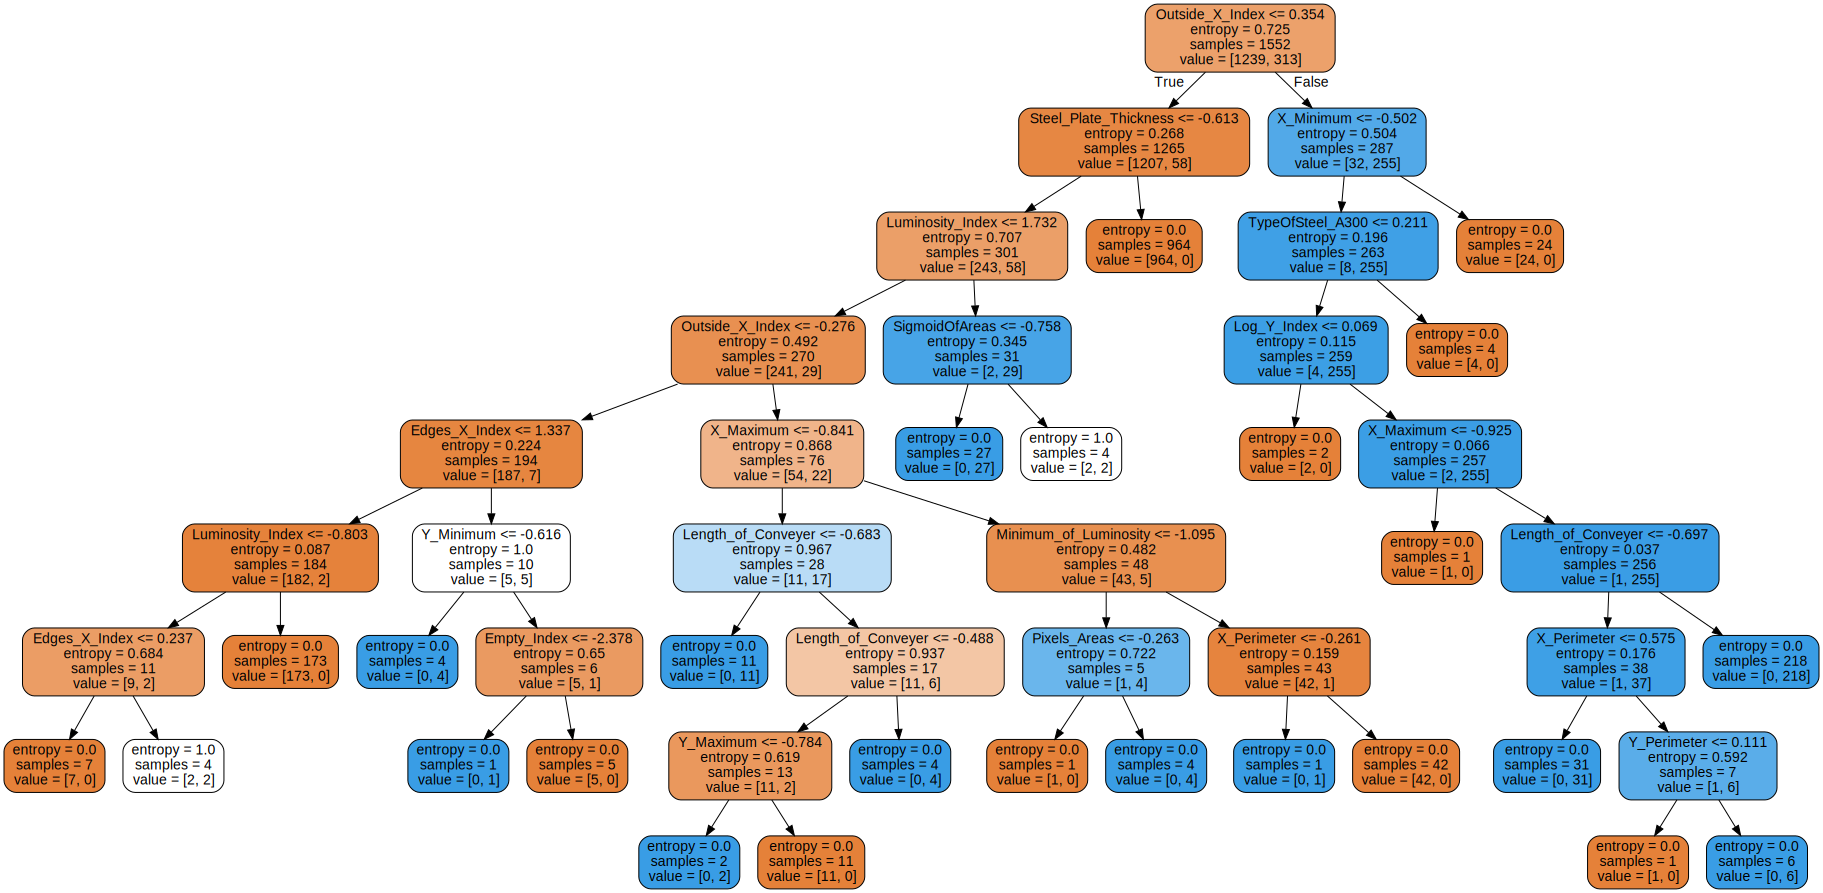

In [ ]:
# tree plot

import graphviz
from sklearn import tree

dt2 = DecisionTreeClassifier(criterion='entropy',max_depth=None,max_features=None,min_samples_leaf=1,min_samples_split=5)
dt2.fit(x_train,y_train)
dot_data = tree.export_graphviz(dt2,feature_names=x_train.columns,filled=True,rounded=True)
graph = graphviz.Source(dot_data)
graph

## Random Forest
1. Bagging
  - Bootstrapping: 복원추출을 통하여 샘플 구성이 조금씩 다른 여러 데이터셋을 생성
  - Aggregating: 여러 모형의 결과를 더하거나 평균을 내서 통합
2. Drop-out : Tree를 구성할 때 변수를 일부 탈락시켜서 Tree간의 correlation을 감소시킴
3. Decision Trees의 변동성을 완화시키고 예측력을 높인 모델  
4. 단점 : 해석력이 떨어짐, 시간이 오래걸림  

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()

### Grid Search

In [ ]:
parameters = {
    'n_estimators':[50,100], 
    'criterion':['entropy'], 
    'min_samples_split':[1,2,5], 
    'max_depth':[None,1,2], 
    'min_samples_leaf':[1,2,3,10], 
    'max_features':['sqrt']
    }
GSRF = GridSearchCV(rf, parameters, cv=10, n_jobs=n_thread, scoring="accuracy")
GSRF.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [ ]:
print('final params', GSRF.best_params_)
print('ACC.', GSRF.best_score_)

final params {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
ACC. 0.9845244003308521


### 모형 평가 : Accuracy 0.985

In [ ]:
predict = GSRF.predict(x_test)
cm = confusion_matrix(y_test, predict)

print(cm)
print("\n Accuracy:", round(GSRF.score(x_test,y_test), 4))
print(metrics.classification_report(y_test, predict))

[[309   2]
 [  4  74]]

 Accuracy: 0.9846
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       311
           1       0.97      0.95      0.96        78

    accuracy                           0.98       389
   macro avg       0.98      0.97      0.98       389
weighted avg       0.98      0.98      0.98       389



## Support Vector Machine
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [ ]:
from sklearn import svm

In [ ]:
svc = svm.SVC()

### Grid Search
- C: Error를 허용하는 정도
- kernel: 비선형 데이터를 다룰 때 사용하는 옵션

In [ ]:
parameters = {
    'C':[0.01,0.1,0.5,0.9,1,5,10],
    'kernel':['linear','rbf','poly'],
    'gamma':[0.01, 0.1, 0.2, 1,10]
    }
GS_SVM = GridSearchCV(svc, parameters, cv=10, n_jobs=n_thread, scoring="accuracy")
GS_SVM.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=4,
             param_grid={'C': [0.01, 0.1, 0.5, 0.9, 1, 5, 10],
                         'gamma': [0.01, 0.1, 0.2, 1, 10],
                         'kernel': ['linear', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
print('final params',GS_SVM.best_params_)
print('best score',GS_SVM.best_score_)

final params {'C': 5, 'gamma': 0.2, 'kernel': 'rbf'}
best score 0.9851778329197686


### 모형 평가 : Accuracy 0.938

In [ ]:
predict = GS_SVM.predict(x_test)
cm = confusion_matrix(y_test, predict)

print(cm)
print("\n Accuracy:", round(GS_SVM.score(x_test,y_test), 4))
print(metrics.classification_report(y_test, predict))

[[310   1]
 [ 23  55]]

 Accuracy: 0.9383
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       311
           1       0.98      0.71      0.82        78

    accuracy                           0.94       389
   macro avg       0.96      0.85      0.89       389
weighted avg       0.94      0.94      0.93       389



## ANN(인공 신경망)
1. 신경망 모형은 Perceptron을 중첩시키고 혼합시킨 구조
2. Hidden Layer: 입력 데이터 혹은 또 다른 hidden layer의 출력값을 입력값으로 하는 perceptron이 위치하는 layer

- https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html  

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
ann = MLPClassifier(random_state=100)

### Grid Search
- 히든레이어는 1개로도 충분한 경우가 많음
- 히든노드의 수는 아래식을 활용하여 grid search 해보기

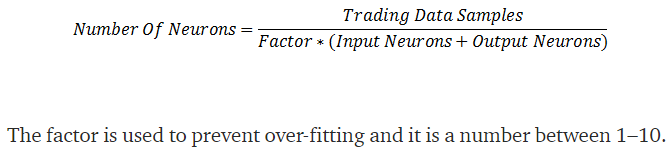

In [ ]:
x_train.shape

(1552, 26)

In [ ]:
# Number of Neurons min값
1552/(10*(26+1))

5.7481481481481485

In [ ]:
# Number of Neurons max값
1552/(1*(26+1))

57.48148148148148

In [ ]:
parameters = {
    'alpha':[1e-3,1e-1,1e1],
    'hidden_layer_sizes':[(5),(30),(60)],
    'activation':['tanh','relu'],
    'solver':['adam','lbfgs']
    }
GS_ANN=  GridSearchCV(ann, parameters, cv=10, n_jobs=n_thread, scoring="accuracy")
GS_ANN.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=100, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'a

In [ ]:
print('final params', GS_ANN.best_params_)
print('best score', GS_ANN.best_score_)

final params {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 60, 'solver': 'lbfgs'}
best score 0.9838875103391234


In [ ]:
means = GS_ANN.cv_results_['mean_test_score']
stds = GS_ANN.cv_results_['std_test_score']
params = GS_ANN.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print("%.4f (+/-%.4f) for %r"
          % (mean, std * 2, param))

0.9723 (+/-0.0230) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 5, 'solver': 'adam'}
0.9710 (+/-0.0211) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 5, 'solver': 'lbfgs'}
0.9768 (+/-0.0232) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 30, 'solver': 'adam'}
0.9716 (+/-0.0290) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 30, 'solver': 'lbfgs'}
0.9807 (+/-0.0191) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 60, 'solver': 'adam'}
0.9839 (+/-0.0104) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 60, 'solver': 'lbfgs'}
0.9723 (+/-0.0237) for {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 5, 'solver': 'adam'}
0.9710 (+/-0.0210) for {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 5, 'solver': 'lbfgs'}
0.9755 (+/-0.0250) for {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 30, 'solver': 'adam'}
0.9794 (+/-0.0171) for {'activation': 'tanh', 'alpha

In [ ]:
# 더 최적의 히든 노드의 수를 찾기 위한 과정

parameters2 = {
    'alpha':[1e-3],
    'hidden_layer_sizes':[(30),(40),(50),(60),(70)],
    'activation':['tanh'],
    'solver':['lbfgs']
    }
GS_ANN2 = GridSearchCV(ann, parameters2, cv=10, n_jobs=n_thread, scoring="accuracy")
GS_ANN2.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=100, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'a

In [ ]:
# 결과: 히든 노드의 수는 60일 때 가장 좋음

means = GS_ANN2.cv_results_['mean_test_score']
stds = GS_ANN2.cv_results_['std_test_score']
params = GS_ANN2.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print("%.4f (+/-%.4f) for %r"
          % (mean, std * 2, param))

0.9716 (+/-0.0290) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 30, 'solver': 'lbfgs'}
0.9794 (+/-0.0181) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 40, 'solver': 'lbfgs'}
0.9774 (+/-0.0202) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 50, 'solver': 'lbfgs'}
0.9839 (+/-0.0104) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 60, 'solver': 'lbfgs'}
0.9807 (+/-0.0216) for {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 70, 'solver': 'lbfgs'}


In [ ]:
# 히든레이어 수 2개나 5개일 때는 어떤지 확인

parameters3 = {
    'alpha':[1e-1],
    'hidden_layer_sizes':[(40,2),(40,5)],
    'activation':['tanh'],
    'solver':['lbfgs']
    }
GS_ANN3 = GridSearchCV(ann, parameters3, cv=10, n_jobs=n_thread, scoring="accuracy")
GS_ANN3.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=100, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'a

In [ ]:
print('final params', GS_ANN3.best_params_)
print('best score', GS_ANN3.best_score_)

final params {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (40, 5), 'solver': 'lbfgs'}
best score 0.982597187758478


### 모형 평가 : Accuracy 0.985

In [ ]:
predict = GS_ANN.predict(x_test)
cm = confusion_matrix(y_test, predict)

print(cm)
print("\n Accuracy:", round(GS_ANN.score(x_test,y_test), 4))
print(metrics.classification_report(y_test, predict))

[[309   2]
 [  4  74]]

 Accuracy: 0.9846
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       311
           1       0.97      0.95      0.96        78

    accuracy                           0.98       389
   macro avg       0.98      0.97      0.98       389
weighted avg       0.98      0.98      0.98       389



## XGBoost
1. gradient boosting의 단점인 과적합을 방지하기 위해 regularization term이 추가된 형태
2. 오분류된 데이터에 가중치를 더 주어 샘플링하면서 궁극적으로 합성 분류기를 구성
3. 성능이 떨어지는 모델 여러개가 모여서 성능이 좋은 모델을 만들어 냄

- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [ ]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic')

### Grid Search
- n_estimators : 반복 수행하려는 개별 결정트리의 개수
- colsample_bytree : 매iteration마다 feature를 랜덤하게 추출하는 비율


In [ ]:
parameters = {
    'max_depth':[5,8],
    'min_child_weight':[1,5],
    'gamma':[0,1],
    'colsample_bytree':[0.8,1],
    'colsample_bylevel':[0.9,1],
    'n_estimators':[50,100]
}


In [ ]:
GS_xgb = GridSearchCV(xgb_model, param_grid=parameters, cv=10, n_jobs=n_thread, scoring="accuracy")
GS_xgb.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'colsample_bylevel': [0.9, 1],
                         'colsample_bytree': [0.8, 1], 'gamma': [0, 1],
                         'max_depth': [5, 8], 'min_

In [ ]:
# " 'colsample_bytree': 1, 'colsample_bylevel': 1 " 의미: 변수를 다 가져와서 트리나 노드를 구성해라, 모델 복잡성이 상대적으로 높음

print('final params', GS_xgb.best_params_)
print('best score', GS_xgb.best_score_)

final params {'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100}
best score 0.9851819685690654


In [ ]:
parameters2 = {
    'max_depth':[3,5,7],
    'min_child_weight':[1],
    'gamma':[0],
    'colsample_bytree':[1],
    'colsample_bylevel':[1],
    'n_estimators':[100,150]
}

GS_xgb2 = GridSearchCV(xgb_model, param_grid=parameters2, cv=10, n_jobs=n_thread, scoring="accuracy")
GS_xgb2.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'colsample_bylevel': [1], 'colsample_bytree': [1],
                         'gamma': [0], 'max_depth': [3, 5, 7],
                         'min_child_weig

In [ ]:
print('final params',GS_xgb2.best_params_)
print('best score',GS_xgb2.best_score_)

final params {'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 150}
best score 0.9877502067824647


In [ ]:
parameters3 = {
    'max_depth':[2,3,4,5],
    'min_child_weight':[1],
    'gamma':[0],
    'colsample_bytree':[1],
    'colsample_bylevel':[1],
    'n_estimators':[150, 200, 250]
}

GS_xgb3 = GridSearchCV(xgb_model, param_grid=parameters3, cv=10, n_jobs=n_thread, scoring="accuracy")
GS_xgb3.fit(x_train, y_train)

print('final params',GS_xgb3.best_params_)
print('best score',GS_xgb3.best_score_)

final params {'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150}
best score 0.9877502067824648


### 모형 평가 : Accuracy 0.985

In [ ]:
predict = GS_xgb3.predict(x_test)
cm = confusion_matrix(y_test, predict)

print(cm)
print("\n Accuracy:", round(GS_xgb3.score(x_test,y_test), 4))
print(metrics.classification_report(y_test, predict))

[[309   2]
 [  4  74]]

 Accuracy: 0.9846
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       311
           1       0.97      0.95      0.96        78

    accuracy                           0.98       389
   macro avg       0.98      0.97      0.98       389
weighted avg       0.98      0.98      0.98       389



## lightGBM
1. xgboost와 성능이 비슷하지만 빠름
2. leaf-wise loss를 사용: 시간과 메모리를 절약하여 fitting 속도가 빠름
3. 데이터의 수가 충분하지 않다면 과적합의 위험이 좀 더 높음

- https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

In [ ]:
import lightgbm as lgb

In [ ]:
lgbm_model = lgb.LGBMClassifier(objecve='binary')

### Grid Search
- feature_fraction : 매iteration마다 feature를 랜덤하게 추출하는 비율, colsample_bytree와 동일
- bagging_fraction : 데이터 샘플링 비율
- num_leaves = 2^(max_depth)


In [ ]:
parameters = {
    'num_leaves':[32,64,128],
    'min_data_in_leaf':[1,5,10],
    'feature_fraction':[0.8,1],
    'bagging_fraction':[0.8,1],
    'n_estimators':[100,150]
}

In [ ]:
GS_lgbm = GridSearchCV(lgbm_model, parameters, cv=10, n_jobs=n_thread, scoring="accuracy")
GS_lgbm.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      objecve='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=4,
             param_grid={'bagging_fracti

In [ ]:
print('final params', GS_lgbm.best_params_)
print('best score', GS_lgbm.best_score_)

final params {'bagging_fraction': 0.8, 'feature_fraction': 0.8, 'min_data_in_leaf': 10, 'n_estimators': 150, 'num_leaves': 128}
best score 0.9890405293631102


### 모형 평가 : Accuracy 0.985

In [ ]:
predict = GS_lgbm.predict(x_test)
cm = confusion_matrix(y_test, predict)

print(cm)
print("\n Accuracy:", round(GS_lgbm.score(x_test,y_test), 4))
print(metrics.classification_report(y_test, predict))

[[309   2]
 [  4  74]]

 Accuracy: 0.9846
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       311
           1       0.97      0.95      0.96        78

    accuracy                           0.98       389
   macro avg       0.98      0.97      0.98       389
weighted avg       0.98      0.98      0.98       389

